<a href="https://colab.research.google.com/github/zhanninna/Neural-Networks/blob/main/WMA05_s18783.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projekt 5: Sieći neuronowe 
> *S18783*



For start the network ,firstly in runtime change runtime type set hardware accelerator on TPU
Some time u have the message that tpu is auavailable so just wait when it was available and try later

# 1. *Import of libraries*

In [ ]:
import numpy as np
import tensorflow as tf
import os
#import pandas as pd
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from google.colab import files
import matplotlib.pyplot as plt
%matplotlib inline 

# 2. Name of classes from datasets


In [ ]:
classes = np.array(['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'])

# 3. Downloading data

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

report the information about test and train sets ,that training batches contains 50000  images and 10000 test images.

In [ ]:
print(f'The data dimension of the training set: {x_train.shape}')
print(f'The data dimension of the test set: {x_test.shape}')

The data dimension of the training set: (50000, 32, 32, 3)
The data dimension of the test set: (10000, 32, 32, 3)


**Example of object**

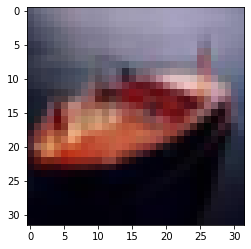

Number of class: [8]
Type of this object: ship


In [ ]:
n = 9545
plt.imshow(x_train[n])
plt.show()
print("Number of class:", y_train[n])
print("Type of this object:", classes[y_train[n][0]])

**Example of samples**

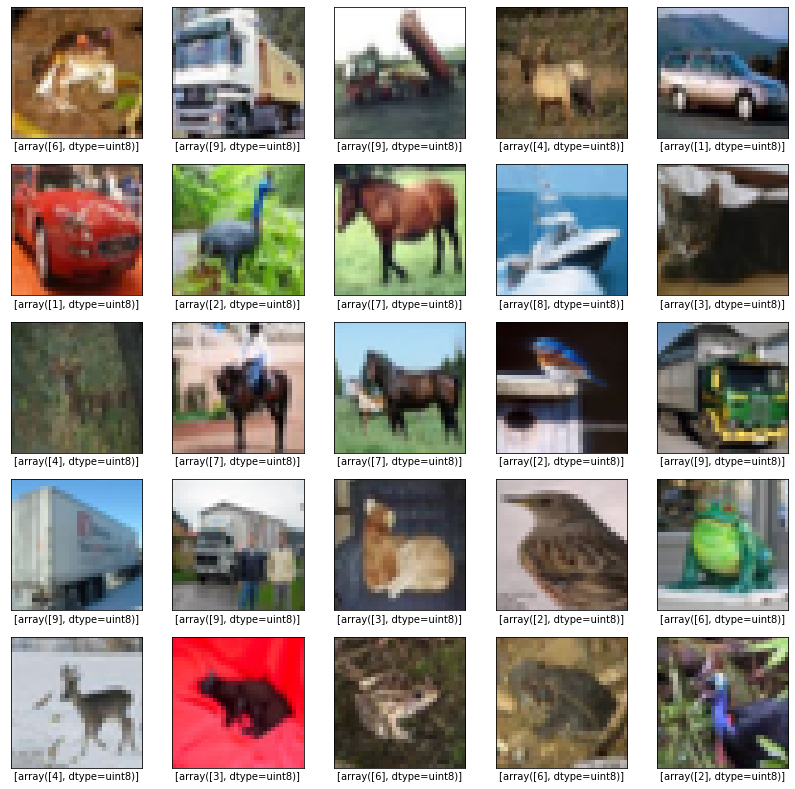

In [ ]:
fig = plt.figure(figsize=(14,14))
fig.tight_layout(pad=0.8, h_pad=2)
for idx in range(25):
    ax = fig.add_subplot(5, 5, idx+1)
    plt.xticks([])
    ax.get_yaxis().set_visible(False)
    ax.grid(False)
    ax.imshow(x_train[idx], cmap=plt.cm.binary)
    ax.set_xlabel([y_train[idx]])
plt.show()

#4. Model Architecture with data conversion(transformation) 
*   by using Adam Optimizer
have faster computation time, and require fewer parameters for tuning it is easy to implements ,work well with large data sets.
*   by using function activation ReLu as advantages Non-Linear and 
Computationally efficient
*  used batch normalization it make neural network faster and stable. The new layer performs the standardizing and normalizing operations on the input of a layer coming from a previous layer. 
*  dense layer is deeply connected layer from its preceding layer which works for changing the dimension of the output by performing matrix vector multiplication
* Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension.


thsi version for tpu accelerator 

In [ ]:
def create_model():
    input_layer = Input(shape=(32, 32, 3), dtype=tf.float32, name='Input')
    x = BatchNormalization()(input_layer)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(10, activation='softmax')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(
        optimizer=tf.compat.v1.train.AdamOptimizer(0.001),
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        metrics=['sparse_categorical_accuracy'])
    return model   

this version when accelerator does not work 

In [ ]:
model = keras.Sequential(name="my_sequential")
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (2, 2), padding='same', activation='relu'))
model.add(Conv2D(64, (2, 2), padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation = 'softmax'))
model.summary()

Model: "my_sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 16, 16, 64)        8256      
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 64)        16448     
                                                                 
 flatten_4 (Flatten)         (None, 16384)             0         
                                                     

In [ ]:
cpu_model = create_model()

In [ ]:
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
TPU_WORKER

'grpc://10.69.157.106:8470'

**transformation from keras to tpu**

* we transform to tpu cause it can radically reduce the time required to execute a single training step

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TPU_WORKER)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.69.157.106:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.69.157.106:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


# 5. Compiling the model with a distribution strategy
* result of this ,the params wich we can train ,all params and params wich we can not use 

this version for tpu 

In [ ]:
with strategy.scope():
  model = create_model()

  model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1), 
                loss=tf.keras.losses.sparse_categorical_crossentropy, 
                metrics=['accuracy'])

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 batch_normalization_10 (Bat  (None, 32, 32, 3)        12        
 chNormalization)                                                
                                                                 
 conv2d_24 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 16, 16, 32)        0   

# 6. Train the model 
* it show us accuracy for our banches and loss
we did not use categorical accuracy cause it make the result worse, i trying to use categorical acc but it give us worse result like only 10 per cent

this version for tpu accelerator 

In [ ]:
history = model.fit(x_train, y_train,
              batch_size=256*8,
              epochs=50,
              verbose=2)

Epoch 1/50
25/25 - 8s - loss: 2.3996 - accuracy: 0.1332 - 8s/epoch - 325ms/step
Epoch 2/50
25/25 - 1s - loss: 2.1716 - accuracy: 0.1940 - 550ms/epoch - 22ms/step
Epoch 3/50
25/25 - 1s - loss: 2.0826 - accuracy: 0.2291 - 558ms/epoch - 22ms/step
Epoch 4/50
25/25 - 1s - loss: 1.9405 - accuracy: 0.2831 - 549ms/epoch - 22ms/step
Epoch 5/50
25/25 - 1s - loss: 1.7926 - accuracy: 0.3465 - 554ms/epoch - 22ms/step
Epoch 6/50
25/25 - 1s - loss: 1.6702 - accuracy: 0.3866 - 552ms/epoch - 22ms/step
Epoch 7/50
25/25 - 1s - loss: 1.5941 - accuracy: 0.4144 - 548ms/epoch - 22ms/step
Epoch 8/50
25/25 - 1s - loss: 1.5443 - accuracy: 0.4384 - 545ms/epoch - 22ms/step
Epoch 9/50
25/25 - 1s - loss: 1.5134 - accuracy: 0.4535 - 546ms/epoch - 22ms/step
Epoch 10/50
25/25 - 1s - loss: 1.4430 - accuracy: 0.4780 - 554ms/epoch - 22ms/step
Epoch 11/50
25/25 - 1s - loss: 1.3928 - accuracy: 0.4958 - 572ms/epoch - 23ms/step
Epoch 12/50
25/25 - 1s - loss: 1.3453 - accuracy: 0.5156 - 559ms/epoch - 22ms/step
Epoch 13/50
25/

version when tpu is not work but it is so long when we didnt use tpu and worse the results 

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=256*8, epochs=25)

Epoch 1/25
25/25 [==============================] - 10s 141ms/step - loss: 0.6803 - accuracy: 0.7561
Epoch 2/25
25/25 [==============================] - 1s 29ms/step - loss: 0.6380 - accuracy: 0.7748
Epoch 3/25
25/25 [==============================] - 1s 30ms/step - loss: 0.6182 - accuracy: 0.7817
Epoch 4/25
25/25 [==============================] - 1s 30ms/step - loss: 0.5974 - accuracy: 0.7854
Epoch 5/25
25/25 [==============================] - 1s 30ms/step - loss: 0.5752 - accuracy: 0.7962
Epoch 6/25
25/25 [==============================] - 1s 31ms/step - loss: 0.5528 - accuracy: 0.8036
Epoch 7/25
25/25 [==============================] - 1s 30ms/step - loss: 0.5332 - accuracy: 0.8109
Epoch 8/25
25/25 [==============================] - 1s 32ms/step - loss: 0.5211 - accuracy: 0.8154
Epoch 9/25
25/25 [==============================] - 1s 32ms/step - loss: 0.4988 - accuracy: 0.8214
Epoch 10/25
25/25 [==============================] - 1s 33ms/step - loss: 0.4780 - accuracy: 0.8305
Epoch 1

the general result of loss and acc 

In [ ]:

test_loss, test_acc = model.evaluate(x_test, y_test)

313/313 [==============================] - 8s 18ms/step - loss: 0.5979 - accuracy: 0.8144



# 7. Ewaluation
from 100 per cent it show result of recognition result

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=0, batch_size=256 * 8)
print("percent results classification of recogniton in percent  : %.2f%%" % (scores[1]*100))

percent results classification of recogniton in percent  : 81.43%


# 8. Save the model
we save the model weights to use it on our network 

In [ ]:
model.save_weights("cifar10_model.h5")

# 9. Example of test data 
choose another one example for testing is it recognise the object 

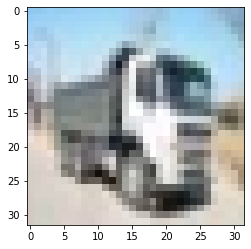

In [ ]:
index=9545
plt.imshow(x_test[index])
plt.show()

# 10. Test image conversion

In [ ]:
x = x_test[index]
x = np.expand_dims(x, axis=0)

# 11. Start recognition

In [ ]:
prediction = model.predict(x)

# 12. Prediction results

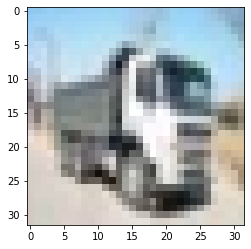

[[2.1952907e-11 3.3255454e-08 1.4154555e-15 1.4344139e-14 4.9961974e-20
  4.8372489e-15 6.3034561e-16 9.5494494e-15 3.3209623e-11 1.0000000e+00]]
9
truck


In [ ]:
plt.imshow(x[0], cmap=plt.cm.binary)
plt.show()
print(prediction )
print(np.argmax(prediction ))
print(classes[np.argmax(prediction)])

In [ ]:
print(prediction)
prediction = np.argmax(prediction)
print(classes[prediction])

[[2.1952907e-11 3.3255454e-08 1.4154555e-15 1.4344139e-14 4.9961974e-20
  4.8372489e-15 6.3034561e-16 9.5494494e-15 3.3209623e-11 1.0000000e+00]]
truck
